# Digit Recognizer

## importing libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imshow
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow import keras
import tensorflow
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation

from tensorflow.python.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.preprocessing import image

from numpy import argmax

## Data description

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

## Data exploration

We start with loading in the data from the csv

In [11]:
#Reading in dataset
df_train = pd.read_csv('../data/train.csv')

In [12]:
df_train.shape

(42000, 785)

We take a quick look at how the data and the features

In [13]:
print(df_train.head(1))

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  

[1 rows x 785 columns]


Next we visualize some data

C:\Users\maxim\AppData\Local\Programs\Python\Python38\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


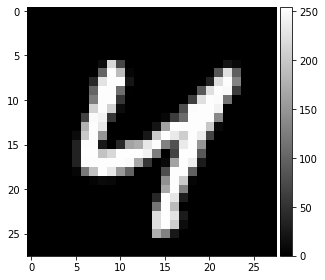

In [14]:

images = df_train.to_numpy()

images = np.delete(images, 0, 1)

imshow(images[888].reshape((28,28)), cmap='gray')


We want to take a look at a batch of data

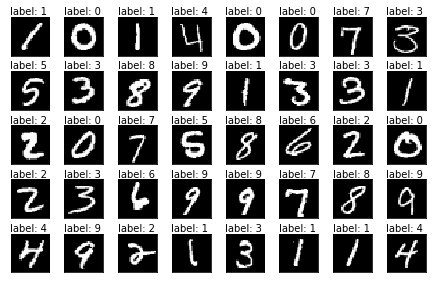

In [15]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(40):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(images[i].reshape((28,28)), cmap='gray', interpolation='nearest')
    ax.text(-1, -2, "label: " + str(df_train['label'][i]))
    fig.tight_layout(pad=0.2)

## Training the model

In [16]:
# Splitting of targets + one-hot encoding
train_labels = df_train.label
y = np_utils.to_categorical(train_labels)

#Splitting of feaures
X = df_train.drop("label",axis=1).values
X = X.reshape((len(X),28, 28,1))

# Normalisation

X =  X/255

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)



print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(33600, 28, 28, 1)
(33600, 10)
(8400, 28, 28, 1)
(8400, 10)


In [17]:
def babysitting(model, layers, nodes):
    for layer in range(layers):
        model.add(Dense(nodes, activation='relu')) 
        #dropout
        #model.add(Dropout(0.01))


In [18]:
# Model
input_shape=(28,28,1)

def get_model1():
    model = Sequential()

    #feature extraction
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(input_shape)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(input_shape)))
    #standaar valid mode


    model.add(MaxPooling2D(pool_size=(2, 2))) #verminderd aantal nodes, maakt het minder complex, dus minder overfit
    model.add(BatchNormalization())

    # mogelijke aanpassingen : kernel size 5x5 
    # uitkomst : 5 x 5 geeft een betere score


    #classificatie layer
    model.add(Flatten()) #het omzetten van een 2d feature map naar een 1d array
    babysitting(model, 1, 10) 
    model.add(Dense(10, activation='softmax')) # 10 categorische outputs 


    # mogelijke aanpassingen : meerdere lagen, kan wel zorgen voor overfitting (babysitting method)
    # mogelijke aanpassingen : meer nodes per laag, kan wel zorgen voor overfitting (babysitting method)
    # uitkomst : 1 layer 10 nodes, 3 layers 20 nodes geven de beste scores
    
    # drop out wordt niet gedaan omdat er minder gewichten zijn, we hebben dit getest en het gaf bij sommige predictions een         betere score maar ons model werd minder consequent had dan slechtere scores bij andere predicties 

    return(model)



model = get_model1() 

model.compile(loss='categorical_crossentropy',
              optimizer='adam', #best
              metrics=['accuracy'])

early_stopping =  EarlyStopping(patience=4)

# Trainen van het CNN
fit1 = model.fit(X_train, y_train,batch_size=64, epochs=100,    
                    validation_split=0.3,  callbacks=[early_stopping], verbose=1)

# mogelijke aanpassingen : batch_size = 32, 64, 128, 256 
# uitkomst : 256 geeft beste scores

Epoch 1/100
368/368 [==============================] - 15s 40ms/step - loss: 0.7649 - accuracy: 0.7442 - val_loss: 0.3075 - val_accuracy: 0.9564
Epoch 2/100
368/368 [==============================] - 14s 38ms/step - loss: 0.0801 - accuracy: 0.9778 - val_loss: 0.0935 - val_accuracy: 0.9721
Epoch 3/100
368/368 [==============================] - 14s 38ms/step - loss: 0.0447 - accuracy: 0.9868 - val_loss: 0.0967 - val_accuracy: 0.9718
Epoch 4/100
368/368 [==============================] - 14s 39ms/step - loss: 0.0295 - accuracy: 0.9903 - val_loss: 0.0797 - val_accuracy: 0.9772
Epoch 5/100
368/368 [==============================] - 14s 38ms/step - loss: 0.0209 - accuracy: 0.9938 - val_loss: 0.0840 - val_accuracy: 0.9783
Epoch 6/100
368/368 [==============================] - 14s 39ms/step - loss: 0.0145 - accuracy: 0.9957 - val_loss: 0.0938 - val_accuracy: 0.9777
Epoch 7/100
368/368 [==============================] - 14s 38ms/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0975 - val_ac

In [19]:
# Accuray 
plt.plot(fit1.history['accuracy'],'b', fit1.history['val_accuracy'],'r',fit_base.history['accuracy'], 'g',fit_base.history['val_accuracy'], 'm' )



plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'train_base', 'val_base'], loc='upper left')
plt.show()
# Loss 
plt.plot(fit1.history['loss'],'b', fit1.history['val_loss'],'r', fit_base.history['loss'],'g', fit_base.history['val_loss'],'m')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'train_base', 'val_base'], loc='upper left')
plt.show()

NameError: name 'fit_base' is not defined

## Prediction

In [20]:
model.predict_classes(X_test[20 : 100])

C:\Users\maxim\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([2, 6, 4, 5, 1, 0, 8, 3, 1, 8, 3, 6, 3, 8, 0, 5, 2, 2, 3, 4, 4, 2,
       8, 6, 9, 5, 3, 5, 9, 3, 8, 7, 9, 8, 8, 5, 2, 3, 3, 5, 5, 5, 7, 6,
       1, 2, 0, 0, 6, 4, 1, 5, 7, 1, 8, 1, 2, 5, 1, 9, 6, 6, 5, 1, 7, 5,
       0, 1, 4, 5, 3, 5, 0, 5, 8, 4, 4, 9, 7, 5], dtype=int64)

We can see the predictions for some data we can see by showing the images that the model has predicted this 2 right. 

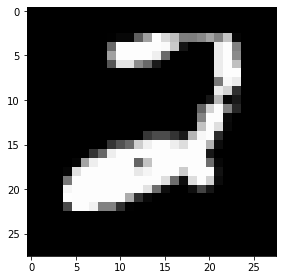

In [21]:
imshow(X_test[20].reshape((28,28)))

Ofcourse we wont do this manually but look at the confusion matrix what the model predicts right and wrong

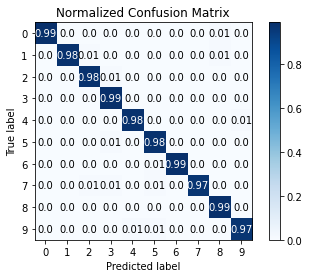

In [22]:
import scikitplot as skplt
from sklearn.metrics import confusion_matrix

test_predict = model.predict_classes(X_test)

# After a train/test split:
confusion_matrix(argmax(y_test, axis=1), test_predict)


skplt.metrics.plot_confusion_matrix(argmax(y_test, axis=1), test_predict, normalize=True)
plt.show()

Now we want to look how well our model has done and we can do this with a classification report

In [23]:
test_predict = model.predict_classes(X_test)
print(classification_report(argmax(y_test, axis=1), test_predict))

## argmax reverse the one hot encoded list back to the categories, this is needed for the classification report

C:\Users\maxim\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       785
           1       0.99      0.98      0.99       949
           2       0.97      0.98      0.98       838
           3       0.97      0.99      0.98       858
           4       0.98      0.98      0.98       796
           5       0.97      0.98      0.97       800
           6       0.99      0.99      0.99      

We can conclude that our model is trained verry well and will almost always work

## Saving the model

In [24]:
model.save('model/')

INFO:tensorflow:Assets written to: model/assets
